一、数据导入与简单分析

In [80]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import glob
import os, sys
import matplotlib.pyplot as plt

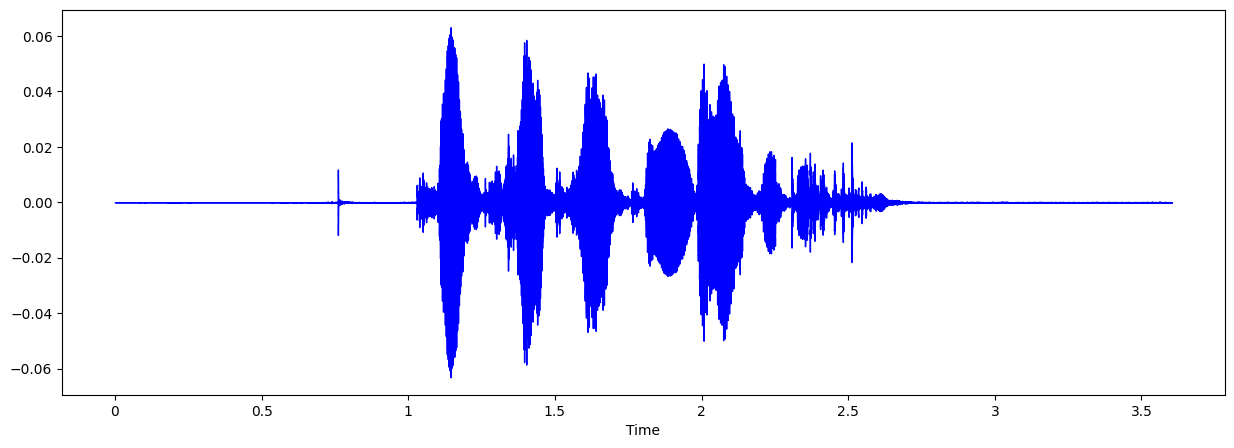

In [81]:
#读取音频数据并绘图展示
data, sampling_rate = librosa.load('D:/project/multi_model/SER/data/RAVDESS_Emotional_speech_audio/Actor_02/03-01-01-01-01-02-02.wav')
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate,color = "blue")

C:\Users\haxia\AppData\Local\Temp\ipykernel_35436\906342419.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read("D:/project/multi_model/SER/data/RAVDESS_Emotional_speech_audio/Actor_02/03-01-01-01-01-02-02.wav")
C:\Users\haxia\AppData\Local\Temp\ipykernel_35436\906342419.py:13: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


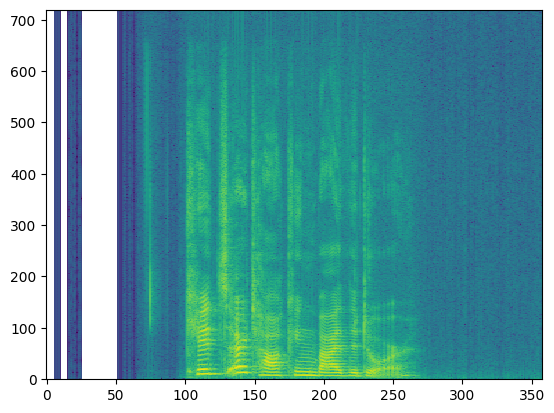

In [82]:
#绘制音频的频谱图
import scipy.io.wavfile
sr,x = scipy.io.wavfile.read("D:/project/multi_model/SER/data/RAVDESS_Emotional_speech_audio/Actor_02/03-01-01-01-01-02-02.wav")
## 参数: 10ms一步, 30ms窗长
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin
window = np.hamming(nwin)
nn = range(nwin, len(x), nstep)
X = np.zeros( (len(nn), nfft//2) )
for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))
plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')
plt.show()

二、数据标签构建与映射

In [83]:
feeling_list=[]
# 所有数据
mylist= os.listdir("D:/project/multi_model/SER/data/audio_speech_actors_01-24")
# 遍历数据
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm') #女性平静
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm') #男性平静
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy') #女性开心
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy') #男性开心
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad') #女性悲伤
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad') #男性悲伤
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry') #女性愤怒
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry') #男性愤怒
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful') #女性恐惧
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful') #男性恐惧
    elif item[:1]=='a':
        feeling_list.append('male_angry') #男性愤怒
    elif item[:1]=='f':
        feeling_list.append('male_fearful') #男性恐惧
    elif item[:1]=='h':
        feeling_list.append('male_happy') #男性开心
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad') #男性悲伤
# 构建label Dataframe
labels = pd.DataFrame(feeling_list)
# 输出前920个样本label
labels[:]


,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
...,...
955,female_fearful
956,male_fearful
957,female_fearful
958,male_fearful


三、数据处理与特征工程

In [84]:
# 构建1个包含feature特征列的Dataframe
df = pd.DataFrame(columns=['feature'])
bookmark=0
# 遍历数据
for index,y in enumerate(mylist):
    if mylist[index][6:-16] not in ['01', '07', '08'] and mylist[index][:2]!='su' and mylist[index][:1] not in ['n','d']:
        X, sample_rate = librosa.load("D:/project/multi_model/SER/data/audio_speech_actors_01-24/"+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        mfccs = librosa.feature.mfcc(y=X, sr=np.array(sample_rate), n_mfcc=13)
        feature = np.mean(mfccs, axis=0)
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1

In [85]:
# 拼接特征与标签
df3 = pd.DataFrame(df['feature'].values.tolist())
newdf = pd.concat([df3,labels], axis=1)
# 重命名标签字段
rnewdf = newdf.rename(index=str, columns={"0": "label"})

四、构建模型

In [86]:
# 打乱样本顺序
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
# 80%的训练集，20%的测试集
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]
# 输出部分数据看看
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
494,-49.257004,-48.980453,-49.989952,-50.774368,-49.990788,-50.253216,-50.450829,-50.275414,-52.041748,-52.055073,...,-41.199402,-42.129177,-43.414059,-43.140335,-42.196327,-43.316612,-45.949394,-41.834919,-36.300613,male_sad
351,-52.565289,-52.565289,-52.565289,-52.565289,-52.565289,-52.565289,-52.565289,-52.565289,-53.494667,-52.641197,...,-46.515129,-47.246284,-49.056274,-51.520058,-51.582493,-50.306419,-51.048622,-52.164761,-51.791912,female_happy
260,-55.943718,-55.943718,-55.943718,-55.542728,-55.431053,-52.677780,-52.143711,-53.764420,-53.548748,-51.339046,...,-44.527973,-45.046982,-46.769386,-47.488022,-46.356987,-46.442314,-46.202965,-47.425095,-50.125832,male_happy
447,-64.336685,-64.336685,-57.387367,-54.829449,-60.108639,-63.158562,-63.970303,-63.356655,-64.336685,-64.336685,...,-61.941772,-61.124729,-60.720135,-62.290791,-61.699337,-62.313168,-63.798576,-60.606853,-59.836014,female_sad
423,-62.267117,-59.308922,-57.283829,-55.204021,-52.429619,-51.848694,-51.590092,-52.608620,-53.694031,-55.538113,...,-57.136406,-58.209126,-57.797951,-59.272518,-58.394058,-57.143211,-57.326042,-57.999004,-57.587997,female_sad
741,-47.379417,-47.379417,-47.379417,-47.395630,-47.436455,-47.356468,-47.264301,-47.361858,-47.499397,-47.417740,...,-31.666048,-32.825962,-33.874664,-33.564278,-32.599800,-31.274477,-30.566969,-22.980629,-16.622139,female_angry
344,-47.679115,-48.275131,-48.317154,-48.317154,-48.317154,-48.317154,-48.317154,-48.317154,-48.317154,-48.317154,...,-44.550430,-43.943230,-43.958614,-44.921379,-45.610142,-45.971916,-44.832512,-44.834213,-46.217167,male_happy
575,-67.927917,-67.927917,-67.927917,-67.927917,-67.927917,-67.927917,-67.927917,-67.927917,-67.927917,-67.927917,...,-57.020786,-49.405746,-45.626831,-44.404461,-46.592545,-46.572342,-44.984604,-32.829262,-25.510805,female_sad
893,-42.751019,-42.751019,-42.719772,-42.308228,-41.886028,-41.338154,-41.120384,-40.377129,-40.439011,-40.034523,...,-34.810783,-37.024025,-37.103134,-35.540901,-35.564041,-37.408527,-38.206787,-37.845577,-39.020306,female_fearful
328,-42.883186,-40.571556,-40.231510,-41.971470,-41.413364,-41.679905,-40.859596,-40.977810,-41.878418,-42.806091,...,-31.011616,-31.791767,-34.396961,-34.452747,-34.094612,-35.161430,-35.944328,-37.427677,-38.765434,male_happy


In [87]:
# 训练集特征与标签
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]
# 测试集特征与标签
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]

import tensorflow
#from tensorflow.keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
# 转为numpy array格式
X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)
# 映射编码
lb = LabelEncoder()
y_train = tensorflow.keras.utils.to_categorical(lb.fit_transform(y_train))
y_test = tensorflow.keras.utils.to_categorical(lb.fit_transform(y_test))

d:\python\anacondaaa\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\python\anacondaaa\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [88]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,Activation,Dropout,MaxPooling1D,Flatten,Dense
# 扩充维度
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)
# 构建CNN序贯模型
model = Sequential()
# 卷积层+激活层
model.add(Conv1D(256, 5,padding='same', input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
# Dropout防止过拟合
model.add(Dropout(0.1))
# 池化层降维
model.add(MaxPooling1D(pool_size=(8)))
# 卷积层+激活层
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
# 展平+全连接层
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
# 输出模型信息
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 216, 256)          1536      
                                                                 
 activation_35 (Activation)  (None, 216, 256)          0         
                                                                 
 conv1d_29 (Conv1D)          (None, 216, 128)          163968    
                                                                 
 activation_36 (Activation)  (None, 216, 128)          0         
                                                                 
 dropout_7 (Dropout)         (None, 216, 128)          0         
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 27, 128)          0         
 1D)                                                             
                                                      

In [89]:
# 编译
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
# 训练

cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=100, validation_data=(x_testcnn, y_test))

Epoch 1/100
50/50 [==============================] - 3s 52ms/step - loss: 2.5348 - accuracy: 0.1070 - val_loss: nan - val_accuracy: 0.0686
Epoch 2/100
50/50 [==============================] - 2s 32ms/step - loss: 2.2792 - accuracy: 0.1376 - val_loss: nan - val_accuracy: 0.1371
Epoch 3/100
50/50 [==============================] - 2s 34ms/step - loss: 2.1605 - accuracy: 0.1987 - val_loss: nan - val_accuracy: 0.2114
Epoch 4/100
50/50 [==============================] - 2s 32ms/step - loss: 1.9905 - accuracy: 0.2510 - val_loss: nan - val_accuracy: 0.2114
Epoch 5/100
50/50 [==============================] - 2s 31ms/step - loss: 1.8962 - accuracy: 0.2599 - val_loss: nan - val_accuracy: 0.1600
Epoch 6/100
50/50 [==============================] - 2s 32ms/step - loss: 1.8305 - accuracy: 0.2790 - val_loss: nan - val_accuracy: 0.2686
Epoch 7/100
50/50 [==============================] - 2s 31ms/step - loss: 1.7240 - accuracy: 0.3490 - val_loss: nan - val_accuracy: 0.3657
Epoch 8/100
50/50 [========

In [90]:
'''import torch
import torch.nn as nn
import torch.optim as optim

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(x_train_cnn.shape)
print(x_test_cnn.shape)
print(y_train.shape)
print(y_test.shape)
# 训练模型
num_epochs = 100
batch_size = 8
for epoch in range(num_epochs):
    for i in range(0, 182, batch_size):
        inputs = inputs.unsqueeze(1) 
        inputs = x_train_cnn[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 在每个epoch结束后计算验证集上的准确率
    with torch.no_grad():
        outputs = model(x_test_cnn)
        _, predicted = torch.max(outputs.data, 1)
        #predicted = predicted.flatten()
        #y_test = y_test.squeeze(dim=1) 
        accuracy = (predicted == y_test).sum().item() / len(y_test)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")'''

'import torch\nimport torch.nn as nn\nimport torch.optim as optim\n\n# 定义损失函数和优化器\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(model.parameters())\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel.to(device)\nprint(x_train_cnn.shape)\nprint(x_test_cnn.shape)\nprint(y_train.shape)\nprint(y_test.shape)\n# 训练模型\nnum_epochs = 100\nbatch_size = 8\nfor epoch in range(num_epochs):\n    for i in range(0, 182, batch_size):\n        inputs = inputs.unsqueeze(1) \n        inputs = x_train_cnn[i:i+batch_size]\n        labels = y_train[i:i+batch_size]\n\n        # 前向传播\n        outputs = model(inputs)\n        loss = criterion(outputs, labels)\n\n        # 反向传播和优化\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n    # 在每个epoch结束后计算验证集上的准确率\n    with torch.no_grad():\n        outputs = model(x_test_cnn)\n        _, predicted = torch.max(outputs.data, 1)\n        #predicted = predicted.flatten()\n        #y_test = y_test.sq

五、模型存储与测试集评估

In [91]:
# 模型存储
# 模型名称
model_name = 'Emotion_Voice_Detection_Model.h5'
# 路径名称
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_path = os.path.join(save_dir, model_name)
# 模型存储
model.save(model_path)
print('模型存储在 %s ' % model_path)
# 模型重加载与测试集评估
from tensorflow import keras
loaded_model = keras.models.load_model(model_path)
# 测试集评估
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

模型存储在 d:\project\multi_model\SER\saved_models\Emotion_Voice_Detection_Model.h5 
accuracy: 45.71%


In [93]:
# 预估得到概率
preds = loaded_model.predict(x_testcnn, batch_size=32, verbose=1)
# 取出概率最高的类别
pred_labels = preds.argmax(axis=1)
# 映射回情绪名称
pred_labels = pred_labels.astype(int).flatten()
predictedvalues = (lb.inverse_transform((pred_labels)))
# 真实测试集标签
actual_labels = y_test.argmax(axis=1).astype(int).flatten()
actualvalues = (lb.inverse_transform((actual_labels)))
# 合并预测标签与真实标签
final_df = pd.DataFrame({'actualvalues': actualvalues, 'predictedvalues': predictedvalues})
# 输出部分结果
final_df[170:176]

6/6 [==============================] - 0s 14ms/step


,actualvalues,predictedvalues
170,male_calm,female_calm
171,female_happy,female_happy
172,female_calm,female_calm
173,male_fearful,male_angry
174,male_angry,male_fearful
